### Importing Libraries

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

if (torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Supported Device: {device}")

# import torch.nn.functional as F
# import pandas as pd
# from einops import rearrange

Supported Device: cpu


### Helper Functions

In [48]:
def proceess_data(data:str, keys:str) -> tuple:
    features = []
    lines = data.split("\n")
    for line in lines:
        features.append(list(map(float, line.split("\t"))))

    np_features = np.array(features).T[::-1,:]
    # print(np_features)
    xscaler = StandardScaler().fit(np_features[:, :-2])
    yscaler = StandardScaler().fit(np_features[:, -2:])
    scaled_features =  np.hstack([xscaler.transform(np_features[:,:-2]),yscaler.transform(np_features[:, -2:])])
    return yscaler, scaled_features

### Data Processing  (Berkshire Hathaway Data)

In [10]:
data = """129619	126401	97322	103869	92774	76332	74803	67145	58535	79209	101760	85385	63822	118906	110518	94623	81506	53378	77745
23758	22435	22353	22566	25128	18602	21136	21718	16434	18125	20460	20027	18685	19435	19210	17923	19898	19172	19962
353842	318621	353409	328161	308793	306167	327662	390538	350719	310739	307942	282097	248027	245317	207454	180782	172757	220051	200516
29066	27496	27493	26403	28050	28714	17494	17596	17375	16658	16542	16533	17505	17152	17132	17583	17325	17535	17208
24681	24009	23530	23144	23208	22094	21877	21265	20751	20397	19900	19449	17527	18584	18175	17660	16280	17135	16807
199646	195214	193160	190181	181381	177850	177288	176722	176364	174123	173652	172789	159276	161539	159902	158522	152408	156556	154719
16947	16284	16028	15674	15584	15139	15125	15038	14918	14752	14659	14567	15065	14714	14887	14899	14298	14934	14741
84626	85652	85853	83502	78119	73395	73618	73822	73875	73770	73758	73695	81882	71865	71753	81659	81025	81228	81269
143743	143451	143020	142887	128308	125794	125369	124920	125475	123195	121646	115460	119827	117506	115631	110292	113361	112330	111168
31914	31173	30359	28657	26878	25727	25368	23512	25239	23732	23756	19782	22018	20992	21718	18093	20764	20113	20172
18556	19635	19937	22421	22305	22562	22673	22452	22409	22106	21709	20155	20975	20642	20193	18632	19422	19155	18918
124781	125347	123624	122744	116496	119081	119661	114262	114965	115223	114531	103368	107691	106689	104233	97490	102194	89907	97193
55077	52233	52525	50116	47971	47580	46005	46072	48132	45544	43693	42319	44026	40665	39614	37186	41189	40588	39807
34473	35140	35156	35167	35190	35204	35586	35592	35603	35635	35630	35658	35621	35615	35619	35707	35612	35610	35622
569776	582543	546631	511602	493438	496126	539881	534421	494775	484431	456337	402493	408791	738654	352359	321112	373334	356846	342773
-74655	-73568	-72265	-67826	-64972	-63934	-62906	-59795	-53072	-45446	-39418	-8125	-24075	-14815	-9700	-3109	-5937	-5252	-4799
531477	517810	465600	468711	406470	408950	528921	450662	411379	418601	385702	347815	320001	267300	272000	339590	311832	318350\t301215
350.29	341	308.76	308.89	267.01	273.01	352.91	299	272.94	277.92	255.47	231.86	212.94	178.50	182.83	226.5	208.02	213.16\t200.89"""

In [11]:
keys = """Short-term investment in U.S. Treasury Bills
FIxed Maturity Securities
Equity Securities
Equity Method Investments
Loans Receiveables
Property, Plant and Equipment
Equipment held for lease/ Service model
Goodwill
Unpaid Losses
Unearned Premiums
Life, Annuity and Insuarance Benefits
Notes payable and other borrowings
Accounts payable
Capital in excess of par value
Retained earnings
Treasury stock, at cost
BRK-A
BRK-B"""

In [49]:
scaler, np_scaled_features = proceess_data(data, keys)
print(np_scaled_features.shape)

(19, 18)


### KT Estimator

In [125]:
class KTEstimator():
    def __init__(self, data:np.array = np_scaled_features, K = 4, T = 1, train_size:float = 0.80) -> None:
        self.K = K
        self.T = T
        self.istrained = False
        self.scaler = scaler
        offset = 1 # Manipulating train-test split to accomodate at least one slab of (K+T) observation in test-set
        train_set, test_set = data[:int(len(data)*train_size)-offset], data[int(len(data)*train_size)-offset:]  
        # Creating Train Feature - Label Matrix        
        train_D = np.zeros(shape=(train_set.shape[1], train_set.shape[0]-(K+T)+1, K))
        train_L = np.zeros(shape=(train_set.shape[0]-(K+T)+1, 2))
        for i in range(train_D.shape[1]):
            train_D[:,i,:] = train_set[i:i+K, :].T
            train_L[i] = train_set[i+K:i+K+T, -2:]
        
        # print(len(train_set), len(test_set))
        # Creating Test Feature - Label Matrix        
        test_D = np.zeros(shape=(test_set.shape[1], test_set.shape[0]-(K+T)+1, K))
        test_L = np.zeros(shape=(test_set.shape[0]-(K+T)+1, 2))
        for i in range(test_D.shape[1]):
            test_D[:,i,:] = test_set[i:i+K, :].T
            test_L[i] = test_set[i+K:i+K+T, -2:]
        
        # print(train_D.shape, test_D.shape)
        X_train = np.zeros(shape = (train_D.shape[1], train_set.shape[1] * K))
        X_test = np.zeros(shape = (test_D.shape[1], test_set.shape[1] * K))

        for i in range(X_train.shape[0]):
            X_train[i] = np.concatenate([arr for arr in train_D[:,i,:]])

        for i in range(X_test.shape[0]):
            X_test[i] = np.concatenate([arr for arr in test_D[:,i,:]])
        
        
        # Test Train Split
        X_train = torch.tensor(X_train, dtype = torch.float32, device = device, requires_grad=False)
        y_train = torch.tensor(train_L,dtype = torch.float32, device = device, requires_grad=False)
        X_test = torch.tensor(X_test,dtype = torch.float32, device = device, requires_grad=False)
        y_test = torch.tensor(test_L,dtype = torch.float32, device = device, requires_grad=False)

        self.X_train, self.X_test, self.y_train, self.y_test, self.train_D, self.train_L, self.test_D, self.test_L = X_train, X_test, y_train, y_test, train_D, train_L, test_D, test_L

        return None
    
    def fit(self, model, convergence:float = 1e-7, num_epochs:int = 2000, batch_size:int = 4, lr:float = 0.001):

        # Training the model
        loss_fn = nn.MSELoss()
        opt = torch.optim.Adam(model.parameters(), lr = lr)
        print_every = 100

        dataset = TensorDataset(self.X_train, self.y_train)
        train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        losses = []
        print(f"Training Tensor shape: {self.X_train.shape}, Testing Tensor shape: {self.X_test.shape}\n")
        for epoch in range(num_epochs):
            l = 0
            for data, target in train_dataloader:
                opt.zero_grad()
                y_pred = model(data)
                loss = loss_fn(y_pred, target)
                l += loss.item()
                loss.backward()
                opt.step()
            
            losses.append(l/len(self.X_train))

            if epoch != 0 and abs(losses[-1] - losses[-2]) < convergence:
                print(f'Final Training Loss: {losses[-1]}')
                print(f'Converged after {epoch} epochs\n')
                break

            if epoch % print_every == 0:
                print(f"Epoch: {epoch} | Loss: {losses[-1]}")
        
        self.train_loss = losses
        self.istrained = True
        return None
    
    def predict(self, model):
        loss_fn = nn.MSELoss()
        # Trained Model Prediction
        predictions = []
        test_losses = []
        with torch.no_grad():
            test_indices = np.arange(0, len(self.X_test))
            for i in test_indices:
                y = model(self.X_test[i])
                loss = loss_fn(y, self.y_test[i])
                predictions.append(np.hstack([scaler.inverse_transform(y.numpy().reshape(1,-1))[0], scaler.inverse_transform(self.y_test[i].numpy().reshape(1,-1))[0]]))
                test_losses.append(loss)
        self.predictions = np.array(predictions)
        self.test_losses = test_losses
        return None

Multilayer Perceptron

In [126]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_size1, hidden_size2, hidden_size3, output_dim):
    super(MLP, self).__init__()
    self.lin1 = nn.Linear(input_dim, hidden_size1)
    self.lin2 = nn.Linear(hidden_size1, hidden_size2)
    self.lin3 = nn.Linear(hidden_size2, hidden_size3)
    self.lin4 = nn.Linear(hidden_size3, output_dim)
  
  def forward(self, x):
    y1 = self.lin1(x)
    y2 = torch.relu(y1)
    y3 = self.lin2(y2)
    y4 = torch.relu(y3)
    y5 = self.lin3(y4)
    y6 = torch.relu(y5)
    y = self.lin4(y6)
    return y

Using `KTEstimator` to make predictions

In [189]:
#Trained Model Prediction
K = 2
T = 1
train_size = 0.75
hidden_size1 = 30
hidden_size2 = 10
hidden_size3 = 5
runs = 20
convergence = 1e-7
num_epochs = 2000
batch_size = 4
lr = 0.01

predictions1 = [] # *****
predictions2 = [] # *****
for i in range(runs):
    print(f"============================= RUN {i+1} =============================")
    est = KTEstimator(np_scaled_features, K, T, train_size)
    model = MLP(input_dim = est.X_train.shape[1], hidden_size1 = hidden_size1 , hidden_size2 = hidden_size2, hidden_size3 = hidden_size3, output_dim = 2)
    est.fit(model, convergence, num_epochs, batch_size, lr)
    est.predict(model)
    predictions1.append(est.predictions[:,0])
    predictions2.append(est.predictions[:,1])
predictions1 = np.array(predictions1)
predictions2 = np.array(predictions2)

============================= RUN 1 =============================
Training Tensor shape: torch.Size([11, 36]), Testing Tensor shape: torch.Size([4, 36])

Epoch: 0 | Loss: 0.27599844336509705
Final Training Loss: 5.5746461095457725e-05
Converged after 70 epochs

============================= RUN 2 =============================
Training Tensor shape: torch.Size([11, 36]), Testing Tensor shape: torch.Size([4, 36])

Epoch: 0 | Loss: 0.2231285355307839
Epoch: 100 | Loss: 0.034513343054145065
Epoch: 200 | Loss: 0.003089105996133929
Epoch: 300 | Loss: 6.337762302295728e-05
Epoch: 400 | Loss: 9.408719820798565e-05
Final Training Loss: 1.7967241092264885e-05
Converged after 431 epochs

============================= RUN 3 =============================
Training Tensor shape: torch.Size([11, 36]), Testing Tensor shape: torch.Size([4, 36])

Epoch: 0 | Loss: 0.26882462203502655
Epoch: 100 | Loss: 1.0389166411848485e-05
Final Training Loss: 5.261087856276638e-06
Converged after 188 epochs

==========

Plotting the predictions

In [190]:
# For BRK A
avg_pred_1 = np.mean(predictions1, axis = 0)
med_pred_1 = np.median(predictions1, axis = 0)

# For BRK B
avg_pred_2 = np.mean(predictions2, axis = 0)
med_pred_2 = np.median(predictions2, axis = 0)

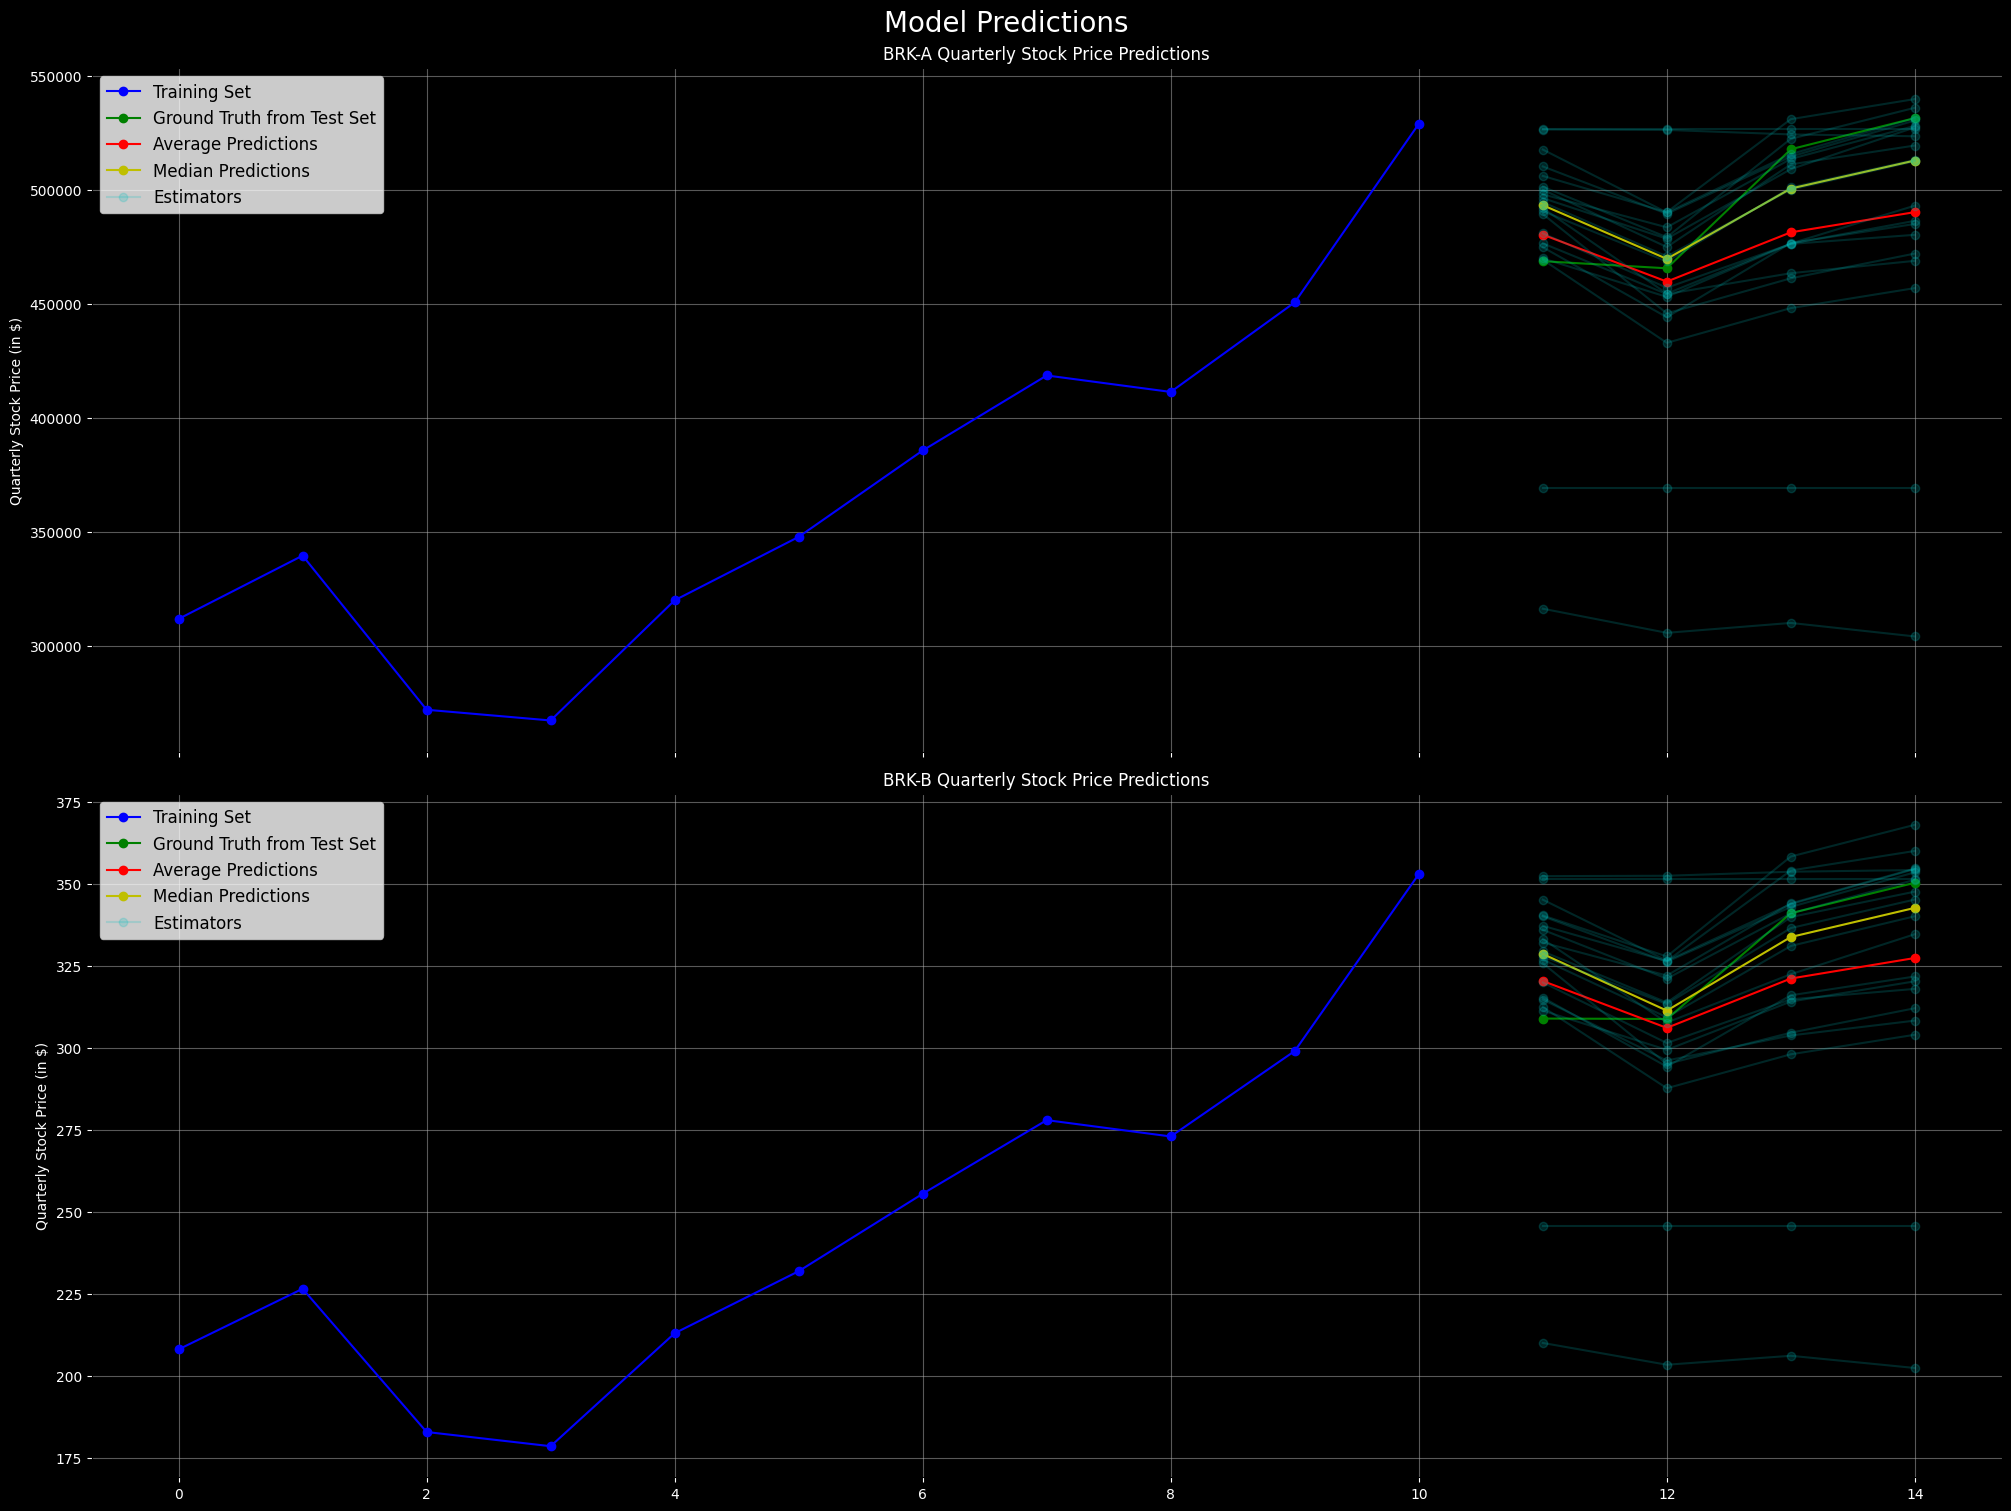

In [214]:
fig, ax = plt.subplots(2, 1, figsize = (20,15), sharex=True, layout  = "constrained")
plt.suptitle("Model Predictions", fontsize = 20, color = 'white')
fig.patch.set_facecolor('#000000')
ax[0].set_title("BRK-A Quarterly Stock Price Predictions", color = 'white')
ax[0].set_ylabel("Quarterly Stock Price (in $)", color = 'white')
ax[0].plot(np.arange(len(est.train_L)), scaler.inverse_transform(est.train_L)[:, 0], 'b-o')
ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), scaler.inverse_transform(est.test_L)[:, 0], 'g-o')
ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), avg_pred_1, 'r-o')
ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), med_pred_1, 'y-o')
for i in range(runs):
    ax[0].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), predictions1[i], 'c-o', alpha = 0.2)
ax[0].legend(["Training Set", "Ground Truth from Test Set", "Average Predictions", "Median Predictions", "Estimators"], fontsize = 12)
ax[0].grid(alpha = 0.5)
ax[0].set_facecolor('#000000')
ax[0].tick_params(axis='both', colors='white')

ax[1].set_title("BRK-B Quarterly Stock Price Predictions", color = 'white')
ax[1].set_ylabel("Quarterly Stock Price (in $)", color = 'white')
ax[1].plot(np.arange(len(est.train_L)), scaler.inverse_transform(est.train_L)[:, 1], 'b-o')
ax[1].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), scaler.inverse_transform(est.test_L)[:, 1], 'g-o')
ax[1].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), avg_pred_2, 'r-o')
ax[1].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), med_pred_2, 'y-o')
for i in range(runs):
    ax[1].plot(np.arange(len(est.train_L), len(est.train_L)+len(est.test_L)), predictions2[i], 'c-o', alpha = 0.2)
ax[1].legend(["Training Set", "Ground Truth from Test Set", "Average Predictions", "Median Predictions","Estimators"], fontsize = 12)
ax[1].grid(alpha = 0.5)
ax[1].set_facecolor('#000000')
ax[1].tick_params(axis='both', colors='white')
plt.show()

Model paramaters

In [215]:
model.parameters

<bound method Module.parameters of MLP(
  (lin1): Linear(in_features=36, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=10, bias=True)
  (lin3): Linear(in_features=10, out_features=5, bias=True)
  (lin4): Linear(in_features=5, out_features=2, bias=True)
)>

In [219]:
scaler.inverse_transform(est.train_L), scaler.inverse_transform(est.test_L)

(array([[3.11832e+05, 2.08020e+02],
        [3.39590e+05, 2.26500e+02],
        [2.72000e+05, 1.82830e+02],
        [2.67300e+05, 1.78500e+02],
        [3.20001e+05, 2.12940e+02],
        [3.47815e+05, 2.31860e+02],
        [3.85702e+05, 2.55470e+02],
        [4.18601e+05, 2.77920e+02],
        [4.11379e+05, 2.72940e+02],
        [4.50662e+05, 2.99000e+02],
        [5.28921e+05, 3.52910e+02]]),
 array([[4.68711e+05, 3.08890e+02],
        [4.65600e+05, 3.08760e+02],
        [5.17810e+05, 3.41000e+02],
        [5.31477e+05, 3.50290e+02]]))